# Spam Detector

Please ensure to un-comment the first cell if you need to install tensorflow and/or spacy before loading the complete notebook.

In [59]:
#!pip install tensorflow
#!python -m spacy download en_core_web_sm -q

In [60]:
#Import required libraries
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import wordcloud

import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import string

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

import warnings
warnings.filterwarnings('ignore')

In [61]:
#Import the dataset with pandas
df = pd.read_csv('https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv', encoding='cp1252')

In [62]:
# Basic stats
def basic_stats(dataframe):
    print(f"Dataframe shape : {dataframe.shape[0]} rows, {dataframe.shape[1]} columns")
    print()
    print('Count of duplicates rows :', len(dataframe)-len(dataframe.drop_duplicates()))
    print()
    
    print("Display of dataset: ")
    display(dataframe.head())
    
    print("Basics statistics: ")
    display(dataframe.describe(include="all"))

    print("Percentage of missing values: ")
    display(100 * dataframe.isnull().sum() / dataframe.shape[0])

    print('Type for each columns')
    display(dataframe.dtypes)

basic_stats(df)

Dataframe shape : 5572 rows, 5 columns

Count of duplicates rows : 403

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

Type for each columns


v1            object
v2            object
Unnamed: 2    object
Unnamed: 3    object
Unnamed: 4    object
dtype: object

In [63]:
#Drop the duplicates
df = df.drop_duplicates()
df.shape

(5169, 5)

In [64]:
#Visualize the target distribution among the dataset
fig = px.pie(df,
             names = "v1",
             title= "Distribution of the category",
             height = 400,
             width = 400)

fig.show()

SPAM category is unbalanced, it will be important to check if there will be enough SPAM messages in our test dataset to let the model practice.

In [65]:
#Remove the last columns and rename the columns we keep
df = df[["v1", "v2"]]
df.rename(columns={"v1": "target", "v2": "msg"}, inplace=True)
df.head()

,target,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Preprocessing

In [66]:
# We start by loading spacy for the preprocessing for the english language and stop words
nlp = en_core_web_sm.load()

It's well known that SPAM messages can contain excessive punctuation,  so we should keep them for our preprocessing.

In [67]:
# Get all string punctuation that we want to keep.
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
# Remove all non alphanumeric characters except whitespaces and punctuation
df["msg_clean"] = df["msg"].apply(lambda x: ''.join(ch for ch in x if ch.isalnum() or ch == " " or ch in "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"))

# # Remove double spaces, spaces at the beginning and end of strings.
df["msg_clean"] = df["msg_clean"].apply(lambda x: x.replace(" +"," ").strip())

# # Remove stop words and replace everyword with their lemma
df["msg_clean"] = df["msg_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

df

,target,msg,msg_clean
0,ham,"Go until jurong point, crazy.. Available only ...","jurong point , crazy .. available bugis n grea..."
1,ham,Ok lar... Joking wif u oni...,ok lar ... joke wif u oni ...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor ... u c ...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I think usf , live"
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u. U win å750 Pound pri...
5568,ham,Will Ì_ b going to esplanade fr home?,Ì _ b esplanade fr home ?
5569,ham,"Pity, * was in mood for that. So...any other s...","pity , * mood . ... suggestion ?"
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching I act like interested buy week free


In [69]:
# Separate HAM and SPAM messages in 2 datasets for the wordclouds
mask_ham = df['target'] == "ham"
df_ham = df[mask_ham]

mask_spam = df['target'] == "spam"
df_spam = df[mask_spam]

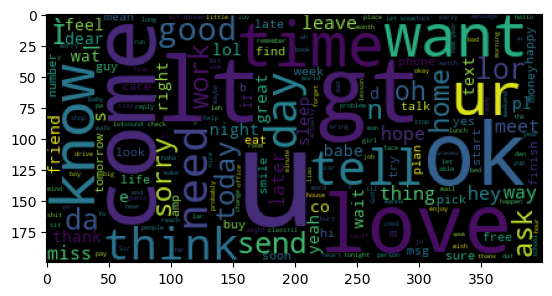

In [70]:
# Merge all messages
ham_text = ' '.join(df_ham['msg_clean'])

# Instanciate WordCloud
wd = wordcloud.WordCloud()
cloud = wd.generate(ham_text)

# Show word cloud with matplotlib
plt.imshow(cloud)

# Remove trailing logs
plt.show()

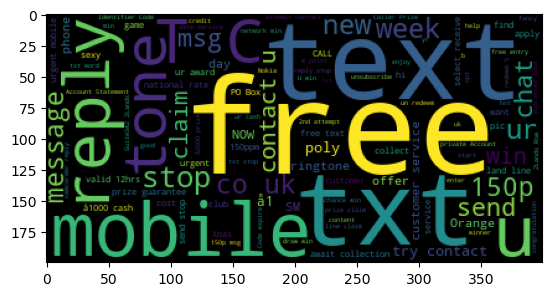

In [71]:
# Same for SPAM words
spam_text = ' '.join(df_spam['msg_clean'])

cloud = wd.generate(spam_text)
plt.imshow(cloud)
plt.show()

We can identify specific spam words in the cloud such as 'reply', 'tone', 'ringtone', 'free'.

In [72]:
#Encode target -> 0 for ham, 1 for spam
label_encoder = LabelEncoder()
df['target_encoded'] = label_encoder.fit_transform(df['target'])
df.head()

,target,msg,msg_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...","jurong point , crazy .. available bugis n grea...",0
1,ham,Ok lar... Joking wif u oni...,ok lar ... joke wif u oni ...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win FA Cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,u dun early hor ... u c ...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I think usf , live",0


In [73]:
# Instanciate the tokenizer -> # num_words indicates the number of words to keep in the tokenization (keep only the common words)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8000, oov_token="out_of_vocab", filters='')

#fit the tokenizer
tokenizer.fit_on_texts(df['msg_clean'])

# This step will effectively transform the texts into sequences of indices and create a column a our dataframe
df["msg_encoded"] = tokenizer.texts_to_sequences(df['msg_clean'])

# Sometimes the preprocessing removes all the words in a string (because they contain
# only stopwords for example) so we calculate the length in order to filter out
# those records
df["len_msg"] = df["msg_encoded"].apply(lambda x: len(x))
df_tokenized = df[df["len_msg"]!=0]

df_tokenized.head()

,target,msg,msg_clean,target_encoded,msg_encoded,len_msg
0,ham,"Go until jurong point, crazy.. Available only ...","jurong point , crazy .. available bugis n grea...",0,"[3334, 255, 4, 470, 9, 495, 916, 46, 64, 276, ...",18
1,ham,Ok lar... Joking wif u oni...,ok lar ... joke wif u oni ...,0,"[20, 199, 7, 527, 290, 8, 1395, 7]",8
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win FA Cup final tkts 2...,1,"[22, 366, 11, 747, 748, 68, 2197, 1056, 496, 2...",24
3,ham,U dun say so early hor... U c already then say...,u dun early hor ... u c ...,0,"[8, 136, 152, 2202, 7, 8, 94, 7]",8
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I think usf , live",0,"[701, 3, 33, 702, 4, 169]",6


In [74]:
# Keep data to make predictions and test the model on unknown values
predictions_df = df_tokenized.tail(100)

# Drop lines which are in the predections dataset
df_tokenized.drop(df_tokenized.tail(100).index,
        inplace = True)

In [75]:
# Ensure predictions dataset has some SPAM messages (due to unbalanced distribution)
fig_pred = px.pie(predictions_df,
             names = "target",
             title= "Distribution of the category",
             height = 400,
             width = 400)

fig_pred.show()

In [76]:
# Padding the sequences so they all have the same lenght
msg_pad = tf.keras.preprocessing.sequence.pad_sequences(df_tokenized['msg_encoded'], padding="post")

In [77]:
# Train Test Split the dataset
X_train, X_val, y_train, y_val = train_test_split(msg_pad,df_tokenized['target_encoded'], test_size=0.3)

In [78]:
# Create the train and validation set
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.shuffle(len(train)).batch(64)
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val = val.shuffle(len(val)).batch(64)

In [79]:
# Let's look at a batch
for message, target in train.take(1):
  print(message, target)

tf.Tensor(
[[ 831  298  194 ...    0    0    0]
 [   8  215  661 ...    0    0    0]
 [ 273 2264    5 ...    0    0    0]
 ...
 [   3   57 6643 ...    0    0    0]
 [1335    2   60 ...    0    0    0]
 [ 102    2   62 ...    0    0    0]], shape=(64, 132), dtype=int32) tf.Tensor(
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0], shape=(64,), dtype=int32)


# Modeling

In [80]:
# Define the model
embedding_dim=8
vocab_size = tokenizer.num_words

model = Sequential([
  Embedding(vocab_size+1, embedding_dim, input_shape=[message.shape[1],], name="embedding"),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 132, 8)         │        64,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,169 (250.66 KB)

 Trainable params: 64,169 (250.66 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Compile the model with the correct lost function, metric and Adam optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [82]:
# Train the model
model_spam = model.fit(train,
                    epochs=100,
                    validation_data=val)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7630 - loss: 0.5164 - val_accuracy: 0.8764 - val_loss: 0.3561
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8787 - loss: 0.3511 - val_accuracy: 0.8764 - val_loss: 0.3556
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8781 - loss: 0.3525 - val_accuracy: 0.8764 - val_loss: 0.3548
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8725 - loss: 0.3602 - val_accuracy: 0.8764 - val_loss: 0.3526
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8772 - loss: 0.3506 - val_accuracy: 0.8764 - val_loss: 0.3511
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8796 - loss: 0.3447 - val_accuracy: 0.8764 - val_loss: 0.3487
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8689 - loss: 0.3618 - val_accuracy: 0.8764 - val_loss: 0.3460
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8723 - loss: 0.3507 - val_accuracy: 0.8764 - v

# Evaluation

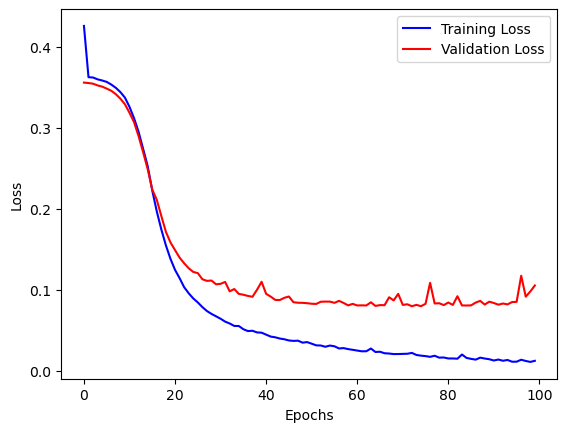

In [83]:
# Visualization of the training process on the loss function
plt.plot(model_spam.history["loss"], color="b", label="Training Loss")
plt.plot(model_spam.history["val_loss"], color="r", label="Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

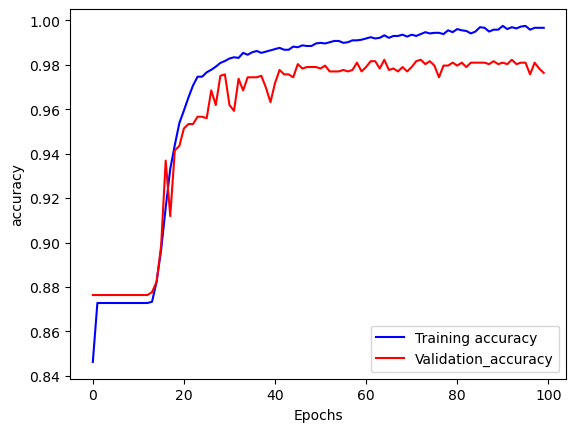

In [84]:
# Visualization of accuracy training
plt.plot(model_spam.history["accuracy"], color="b", label="Training accuracy")
plt.plot(model_spam.history["val_accuracy"], color="r", label='Validation_accuracy')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

We can see thanks to accuracy that most of the predictions of the model are correct, meaning that the model correctly classified 99% of the validation set. The loss function is very low, meaning that the model predictions are not really different from the actual true output.

# Testing the model

Let's test the model on the predictions dataframe we save earlier.

In [85]:
to_keep = ['msg', 'msg_encoded', 'target']
predictions_df = predictions_df.loc[:,to_keep]
predictions_df.head()

,msg,msg_encoded,target
5456,\For the most sparkling shopping breaks from 4...,"[1, 1, 439, 316, 1, 215, 12, 1, 1, 586, 1, 34,...",spam
5459,If you hear a loud scream in about &lt;#&gt; m...,"[175, 1697, 679, 10, 21, 12, 163, 374, 1, 2121...",ham
5461,Ok i thk i got it. Then u wan me 2 come now or...,"[20, 150, 2, 8, 138, 11, 14, 61, 5]",ham
5462,Txt: CALL to No: 86888 & claim your reward of ...,"[38, 26, 26, 3290, 10, 72, 749, 107, 160, 124,...",spam
5463,U GOIN OUT 2NITE?,"[8, 363, 741, 5]",ham


In [88]:
# Prepare the data for predictions
X_test = predictions_df['msg_encoded']
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding="post")

# Make predictions with the model
predictions = model.predict(X_test_pad)

# Save the probability in the dataframe
predictions_df['spam_probability'] = [round(prediction[0]*100) for prediction in predictions]

# Set the probability of the message being considered spam at 70%.
predictions_df['model_prediction'] = predictions_df['spam_probability'].apply(lambda x: "spam" if x >= 75 else "ham")

display(predictions_df.head())

# Count the differences between the reality and model predictions
errors = (predictions_df['target'] != predictions_df['model_prediction']).sum()
print(f"The model made {errors} mistakes.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,msg,msg_encoded,target,spam_probability,model_prediction
5456,\For the most sparkling shopping breaks from 4...,"[1, 1, 439, 316, 1, 215, 12, 1, 1, 586, 1, 34,...",spam,0,ham
5459,If you hear a loud scream in about &lt;#&gt; m...,"[175, 1697, 679, 10, 21, 12, 163, 374, 1, 2121...",ham,0,ham
5461,Ok i thk i got it. Then u wan me 2 come now or...,"[20, 150, 2, 8, 138, 11, 14, 61, 5]",ham,0,ham
5462,Txt: CALL to No: 86888 & claim your reward of ...,"[38, 26, 26, 3290, 10, 72, 749, 107, 160, 124,...",spam,100,spam
5463,U GOIN OUT 2NITE?,"[8, 363, 741, 5]",ham,0,ham


The model made 2 mistakes.


In [89]:
# Let's check on which messages it made errors
mask = predictions_df['target'] != predictions_df['model_prediction']
error_df = predictions_df[mask]
error_df

,msg,msg_encoded,target,spam_probability,model_prediction
5456,\For the most sparkling shopping breaks from 4...,"[1, 1, 439, 316, 1, 215, 12, 1, 1, 586, 1, 34,...",spam,0,ham
5549,"You know, wot people wear. T shirts, jumpers, ...","[17, 4, 334, 184, 807, 2, 378, 838, 4, 1, 4, 1...",ham,97,spam


The spam detection model has mainly made mistakes by classifying non spam-messages as spam. This is less important/serious than classifying spam as a normal message, which can impact users from a security perspective.